In [1]:
import matplotlib.pyplot as plt
import numpy as np
from audio_utils import *
from model import *
from pairs import *
from embeddings import *
from embedding_classifier import *

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
real_audio = 'dataset/en_US/by_book/male/elliot_miller/hunters_space/wavs/'
fake_audio = 'dataset/e2-tts/'

# real_audio = 'dataset/train/real'
# fake_audio = 'dataset/train/fake'

fixed_length = 256
num_items_per_class = 2000
threshold_val = 30
formant_thresh = True

real_audio, fake_audio = load_audio_dataset(real_folder_path=real_audio, 
                                            fake_folder_path=fake_audio, 
                                            fixed_length=fixed_length, 
                                            num_items_per_class=num_items_per_class, 
                                            threshold_val=threshold_val, 
                                            formant_thresh=formant_thresh)

print(f"loaded {len(real_audio)} spectrograms with shape {real_audio[0].shape}.")
print(f"loaded {len(fake_audio)} spectrograms with shape {fake_audio[0].shape}.")

Loading 1826 real and 1000 fake audio files.
loaded 1826 spectrograms with shape torch.Size([1, 1025, 256]).
loaded 1000 spectrograms with shape torch.Size([1, 1025, 256]).


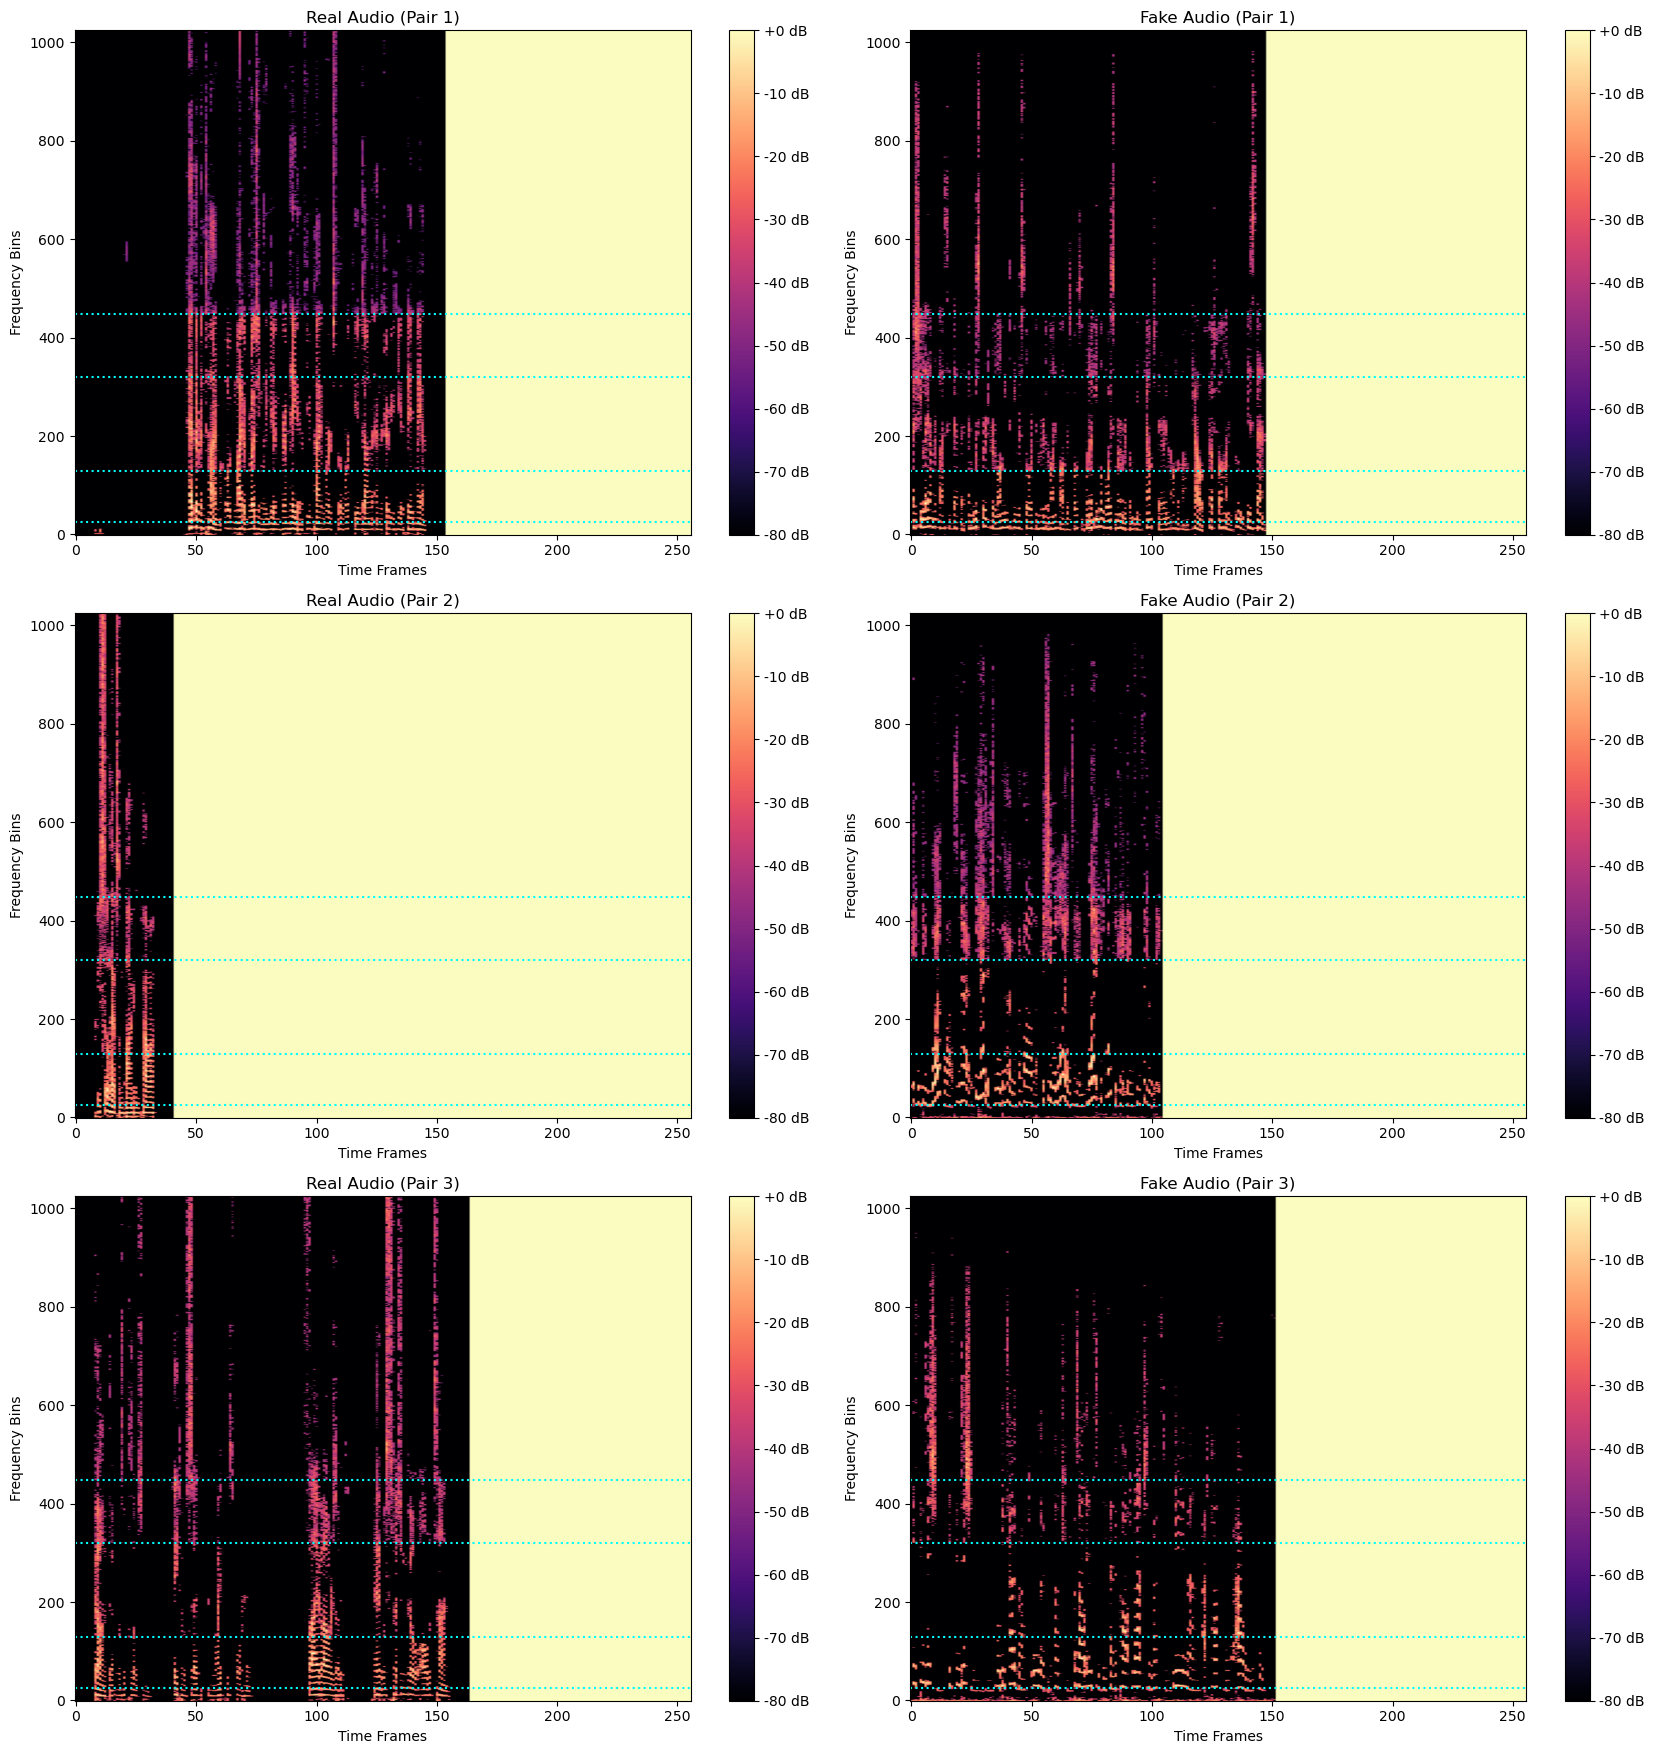

In [3]:
num_pairs = 3
plot_spectrogram_pairs(real_audio_list=real_audio, fake_audio_list=fake_audio, num_pairs=num_pairs, show_formants=True)

In [4]:
pairs, labels, classes = make_positive_negative_pairs(real_audio, fake_audio, num_pairs=5000)

print(f"created {len(pairs)} pairs with {len(labels)} labels and {len(classes)} classes.")

print(pairs[0])
print(labels[0])
print(classes[0])

created 5000 pairs with 5000 labels and 5000 classes.
(tensor([[[-80., -80., -80.,  ...,   0.,   0.,   0.],
         [-80., -80., -80.,  ...,   0.,   0.,   0.],
         [-80., -80., -80.,  ...,   0.,   0.,   0.],
         ...,
         [-80., -80., -80.,  ...,   0.,   0.,   0.],
         [-80., -80., -80.,  ...,   0.,   0.,   0.],
         [-80., -80., -80.,  ...,   0.,   0.,   0.]]]), tensor([[[-80., -80., -80.,  ...,   0.,   0.,   0.],
         [-80., -80., -80.,  ...,   0.,   0.,   0.],
         [-80., -80., -80.,  ...,   0.,   0.,   0.],
         ...,
         [-80., -80., -80.,  ...,   0.,   0.,   0.],
         [-80., -80., -80.,  ...,   0.,   0.,   0.],
         [-80., -80., -80.,  ...,   0.,   0.,   0.]]]))
0
('fake', 'fake')


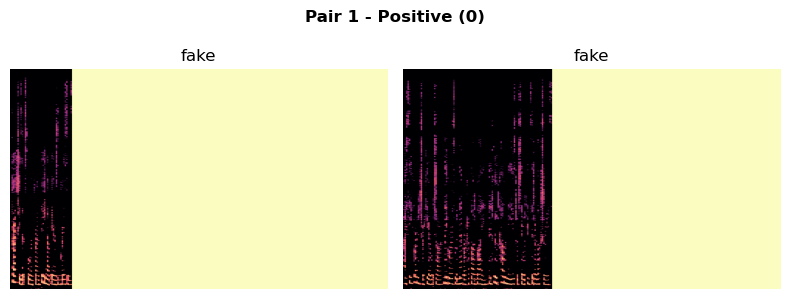

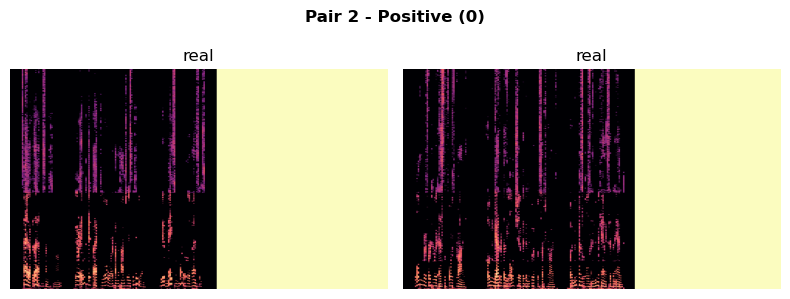

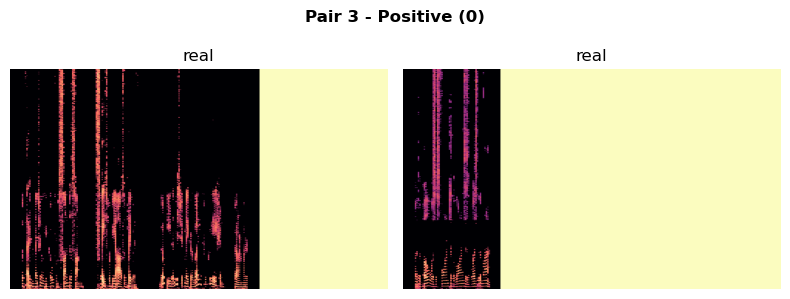

In [5]:
view_pairs(pairs, labels, classes, num_to_show=3)

# Training Phase

In [6]:
dataset = SiamesePairDataset(pairs, labels)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
model = SimpleSiameseCNN(embedding_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = ContrastiveLoss(margin=1.0)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [8]:
train_model(model, train_loader, optimizer, loss_fn, device, epochs=50)

Epoch [1/50] Summary - Loss: 0.8224


Epoch [2/50] Summary - Loss: 0.0210


Epoch [3/50] Summary - Loss: 0.0136


KeyboardInterrupt: 

In [8]:
val_real_path = 'dataset/en_US/by_book/male/elliot_miller/pink_fairy_book/wavs'
val_fake_path = 'dataset/f5-tts'

# val_real_path = 'dataset/test/real'
# val_fake_path = 'dataset/test/fake'

val_real_audio, val_fake_audio = load_audio_dataset(
    real_folder_path=val_real_path,
    fake_folder_path=val_fake_path,
    num_items_per_class=100 # Use a reasonable number for quick plotting
)

validation_data = val_real_audio + val_fake_audio
validation_labels = ['real'] * len(val_real_audio) + ['fake'] * len(val_fake_audio)


Loading 100 real and 100 fake audio files.


Epoch [1/10] Summary - Loss: 0.3356


Epoch [2/10] Summary - Loss: 0.0168


Epoch [3/10] Summary - Loss: 0.0126


Epoch [4/10] Summary - Loss: 0.0106


Epoch [5/10] Summary - Loss: 0.0091


Epoch [6/10] Summary - Loss: 0.0093


Epoch [7/10] Summary - Loss: 0.0080


Epoch [8/10] Summary - Loss: 0.0081


Epoch [9/10] Summary - Loss: 0.0079


Epoch [10/10] Summary - Loss: 0.0077
Generating t-SNE plot for epoch 10...


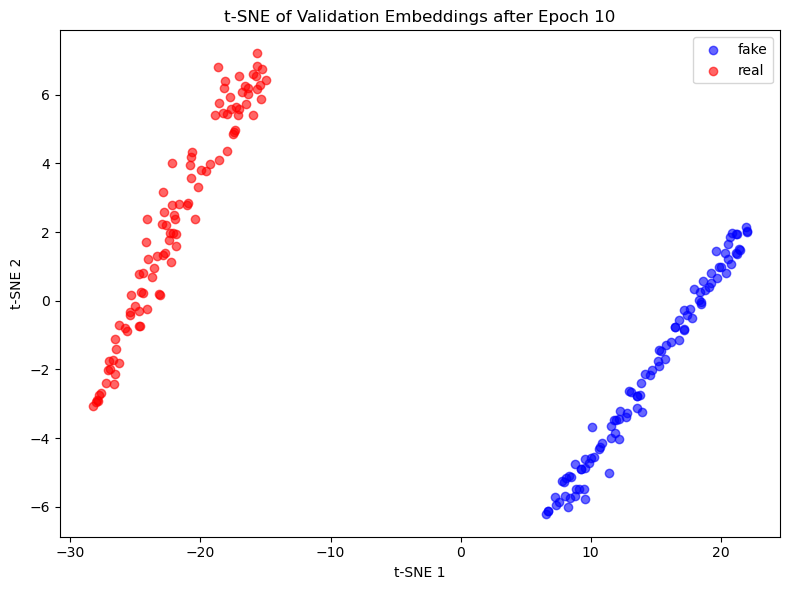

Training complete.


In [9]:
train_model(
    model,
    train_loader,
    optimizer,
    loss_fn,
    device,
    val_data_list=validation_data,
    val_labels=validation_labels,
    plot_every=10,  # Plot every 5 epochs
    epochs=10
)

In [10]:
all_mels = real_audio + fake_audio
all_labels = ['real'] * len(real_audio) + ['fake'] * len(fake_audio)

In [11]:
embeddings = get_embeddings(model, all_mels, device)
plot_tsne(embeddings, all_labels, plot_3d=True)  


In [14]:
torch.save(model, "models/model_thresh_40db_formant_MLAAD_1.5k.pth")

# Testing Phase

In [ ]:
# real_testing_audio = 'dataset/en_US/by_book/male/elliot_miller/pink_fairy_book/wavs'
# fake_testing_audio = 'dataset/f5-tts'

real_testing_audio = 'dataset/test/real'
fake_testing_audio = 'dataset/test/fake'

fixed_length = 35
num_items_per_class = 1000
threshold_val = 30
formant_thresh = True

test_real_audio, test_fake_audio = load_audio_dataset(real_folder_path=real_testing_audio, 
                                            fake_folder_path=fake_testing_audio, 
                                            fixed_length=fixed_length, 
                                            num_items_per_class=num_items_per_class, 
                                            threshold_val=threshold_val, 
                                            formant_thresh=formant_thresh)

print(f"loaded {len(test_real_audio)} spectrograms with shape {test_real_audio[0].shape}.")
print(f"loaded {len(test_fake_audio)} spectrograms with shape {test_fake_audio[0].shape}.")

Loading 408 real and 408 fake audio files.
loaded 408 spectrograms with shape torch.Size([1, 1025, 35]).
loaded 408 spectrograms with shape torch.Size([1, 1025, 35]).


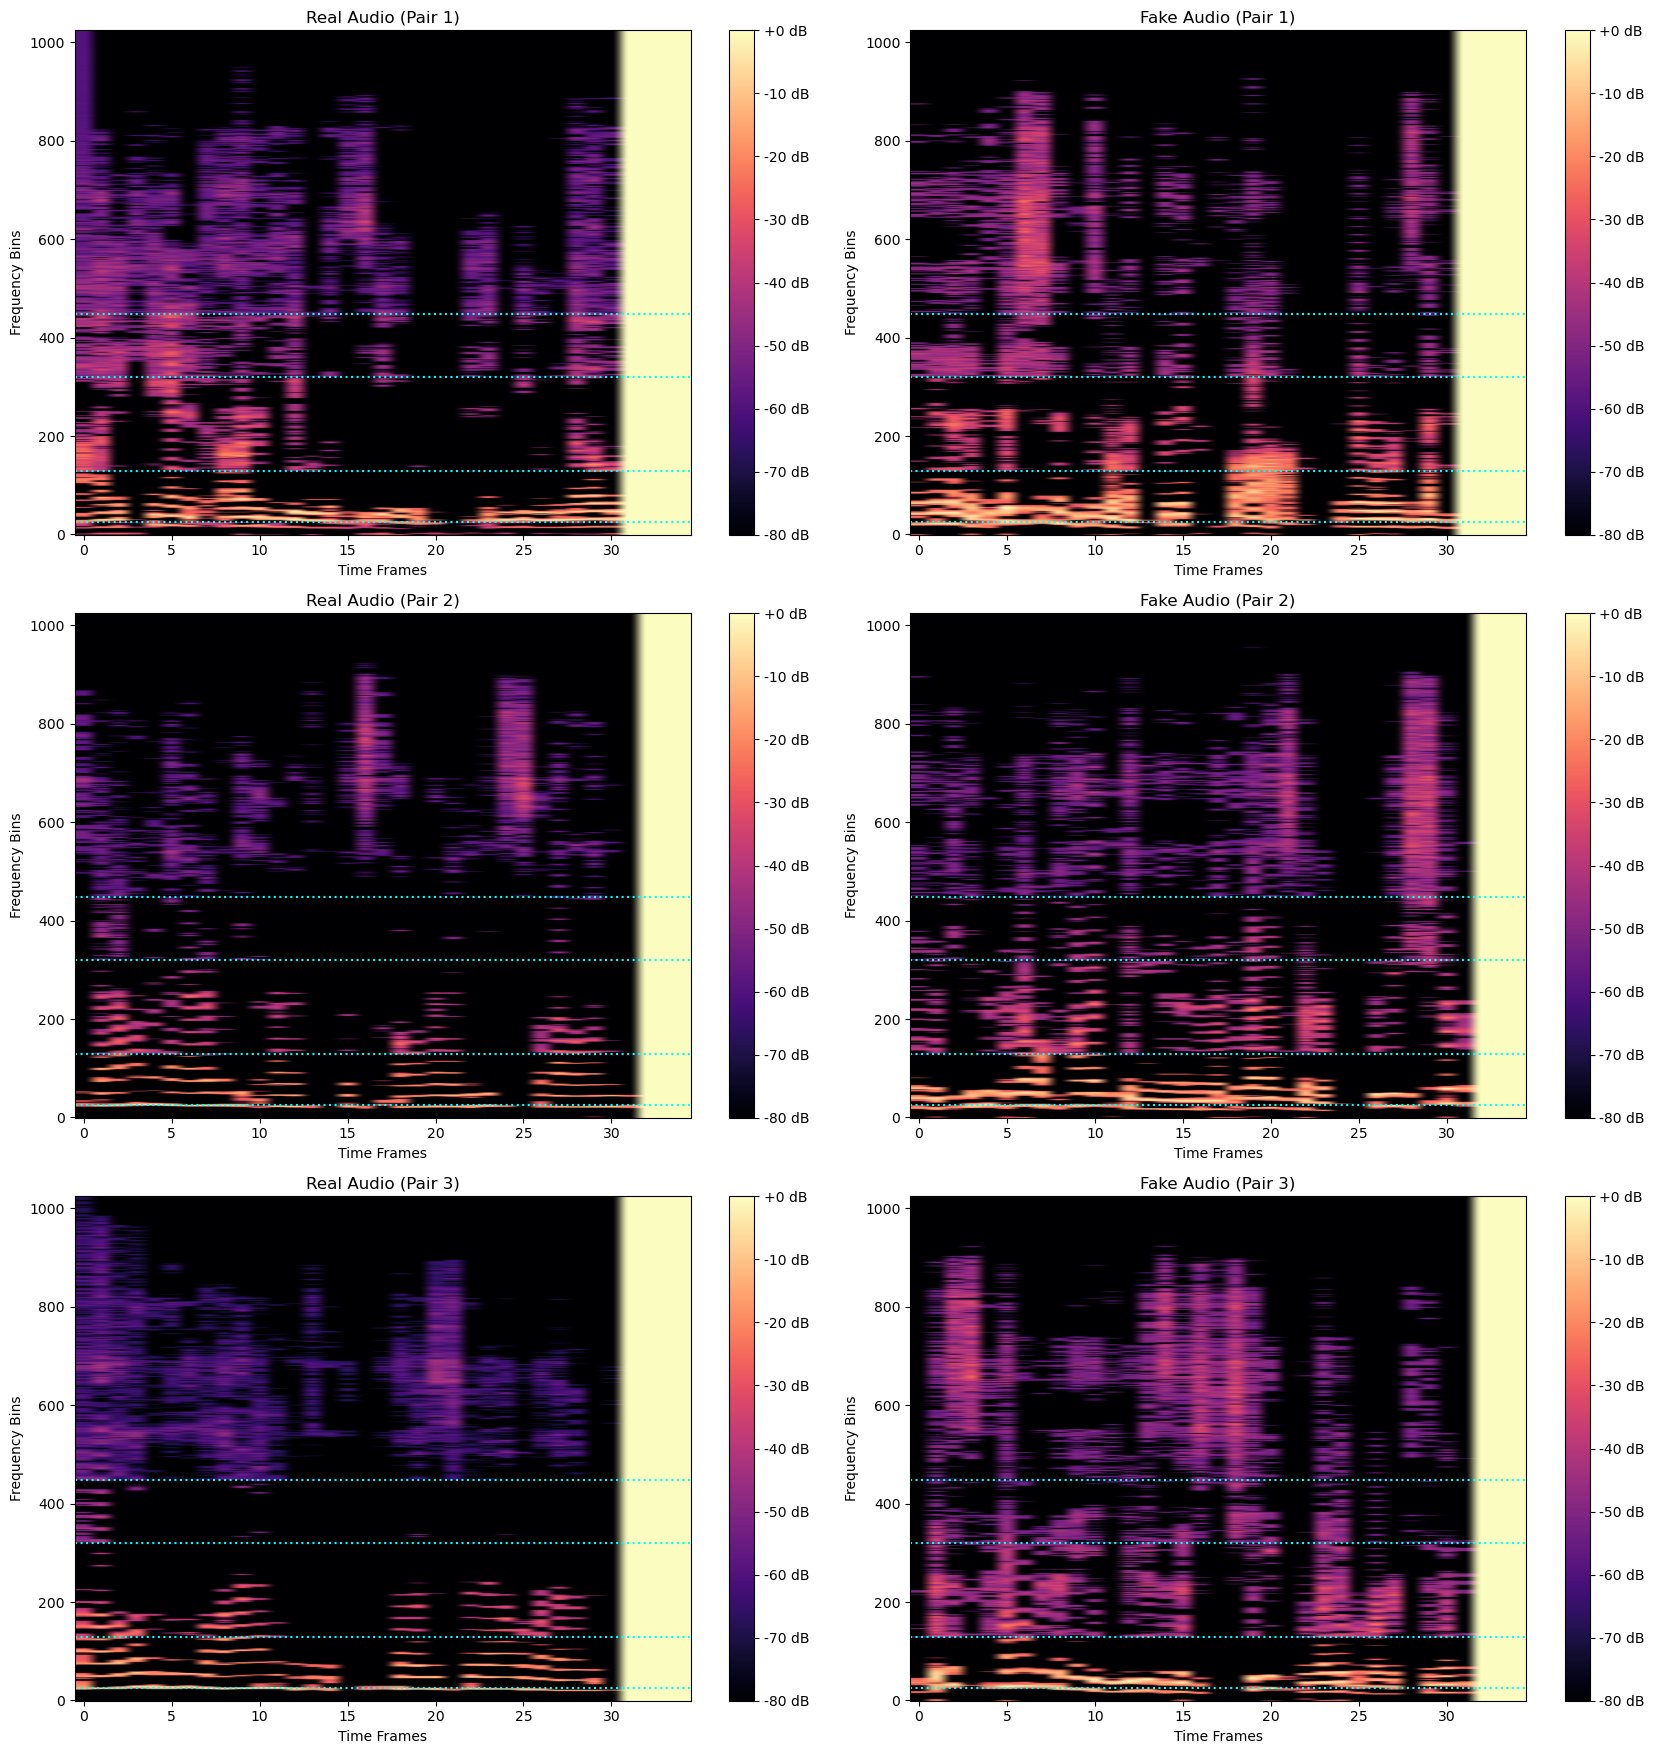

In [33]:
num_pairs = 3
plot_spectrogram_pairs(real_audio_list=test_real_audio, fake_audio_list=test_fake_audio, num_pairs=num_pairs, show_formants=True)

In [34]:
test_pairs, test_labels, test_classes = make_positive_negative_pairs(test_real_audio, test_fake_audio, num_pairs=800)

print(f"created {len(test_pairs)} pairs with {len(test_labels)} labels and {len(test_classes)} classes.")

print(test_pairs[0])
print(test_labels[0])
print(test_classes[0])

created 800 pairs with 800 labels and 800 classes.
(tensor([[[-80.0000, -25.7423, -27.5832,  ...,   0.0000,   0.0000,   0.0000],
         [-80.0000, -27.5388, -30.3762,  ...,   0.0000,   0.0000,   0.0000],
         [-80.0000, -28.1174, -80.0000,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [-80.0000, -80.0000, -80.0000,  ...,   0.0000,   0.0000,   0.0000],
         [-80.0000, -80.0000, -80.0000,  ...,   0.0000,   0.0000,   0.0000],
         [-80.0000, -80.0000, -80.0000,  ...,   0.0000,   0.0000,   0.0000]]]), tensor([[[-80.0000, -80.0000, -34.7559,  ...,   0.0000,   0.0000,   0.0000],
         [-80.0000, -80.0000, -33.2137,  ...,   0.0000,   0.0000,   0.0000],
         [-80.0000, -80.0000, -34.9026,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [-80.0000, -80.0000, -80.0000,  ...,   0.0000,   0.0000,   0.0000],
         [-80.0000, -80.0000, -80.0000,  ...,   0.0000,   0.0000,   0.0000],
         [-80.0000, -80.0000, -80.0000,  ...,   0.0000,   0.0000,   0.

In [35]:
test_mels = test_real_audio + test_fake_audio
all_test_labels = ['real'] * len(test_real_audio) + ['fake'] * len(test_fake_audio)

## Model Loading

In [37]:
model = torch.load("models/model_thresh_40db_formant_MLAAD_1.5k.pth", weights_only=False)
model.eval()

SimpleSiameseCNN(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
  )
)

In [38]:
embeddings = get_embeddings(model, test_mels, device)
plot_tsne(embeddings, all_test_labels, plot_3d=True, title="t-SNE of Test Embeddings.")  

In [39]:
print(embeddings.shape)
print(len(all_test_labels))

(816, 128)
816


In [40]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(all_test_labels)  # now y contains 0s and 1s

# Check mapping
print(label_encoder.classes_)  # Output: ['real' 'fake']
print(y)
print(all_test_labels)

['fake' 'real']
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

Accuracy: 0.6829268292682927
Confusion Matrix:
 [[59 23]
 [29 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.72      0.69        82
           1       0.70      0.65      0.67        82

    accuracy                           0.68       164
   macro avg       0.68      0.68      0.68       164
weighted avg       0.68      0.68      0.68       164



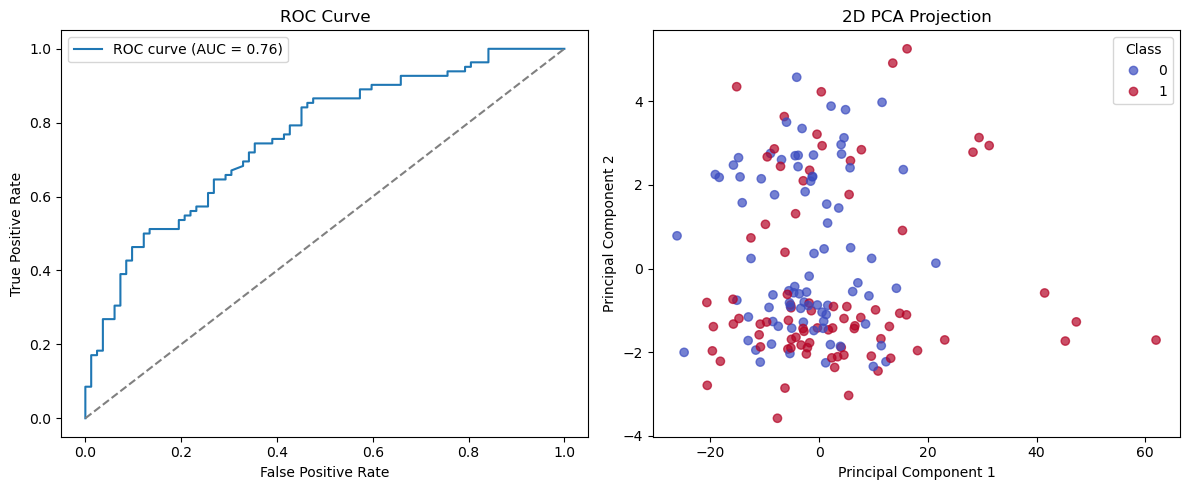

In [41]:
model, X_test, y_test = train_svm_classifier(embeddings, y)
evaluate_model(model, X_test, y_test)

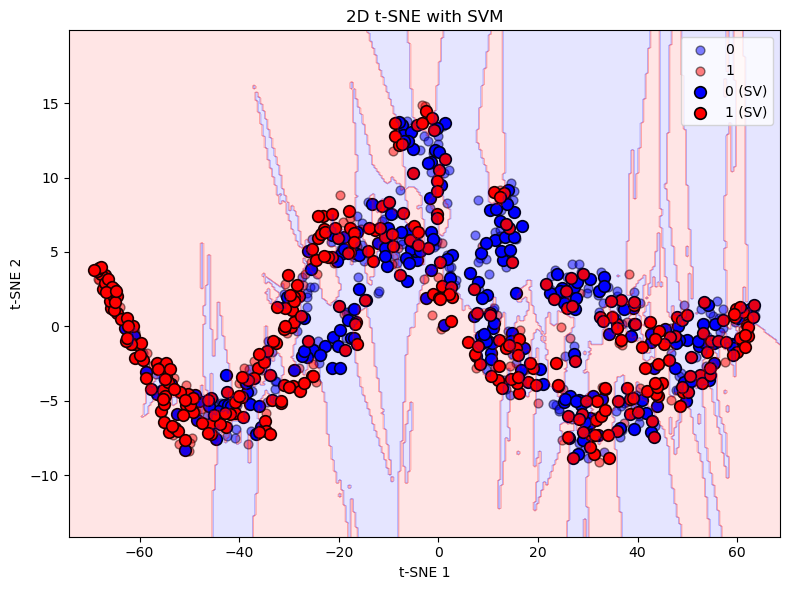

In [42]:
plot_tsne_with_svm_2d(model, embeddings, y)